Take the Frame, Flow and Speech models and make a prediction

# Import Modules

In [1]:
from display import pltDisplay
from datetime import datetime
from pathlib import Path
from sorting import human_sort
# from reload import reload_module
import dlib
# from pyflow import pyflow

# import IPython.display as ipd
# from IPython.display import clear_output
import constants as const
import cv2
import matplotlib.pyplot as plt
# import mtcnn  # https://pypi.org/project/mtcnn/
import librosa
import librosa.display
import numpy as np
import progressbar as pb
import subprocess
import tensorflow as tf
import utils
import utils_flow as ut_fl
import utils_audio as ut_au

from pympler import asizeof

In [2]:
SEED = 42
SEQUENCE_LENGTH = const.MAX_SPEECH_SEQUENCE_LENGTH  # max
SAMPLE_RATE = const.RAVDESS_SAMPLE_RATE

# Dimensions of generated images
IMG_HEIGHT = IMG_WIDTH = 64
MAX_WIDTH = MAX_HEIGHT = const.MAX_WIDTH
label_names = const.EMOTIONS_LABELS_SORTED

# Selection of random videos

In [3]:
# Array of array for every emotion
emotion_arrays = [
    list(
        Path(const.dataset_path)
        .glob(f'*/*/01-01-{i:02d}-*-*-*-*.mp4')
    ) for i in range(1, 9)
]

In [4]:
rnd_gen = np.random.default_rng(seed=SEED)
rnd_idxs = [rnd_gen.integers(len(em_list)) for em_list in emotion_arrays]

In [5]:
rnd_videos = [
    em_list[rnd_idxs[idx]]
    for idx, em_list in enumerate(emotion_arrays)
]

In [6]:
for idx, video in enumerate(rnd_videos):
    print()
    print(f'Video {idx + 1}')
    utils.filename_info(str(video))
    print()


Video 1
Modality: Full-AV
Channel: Speech
Emotion: Neutral
Intensity: Normal
Statement: Kids are talking by the door
Repetition: 1st repetition
Actor: 3 (Male)


Video 2
Modality: Full-AV
Channel: Speech
Emotion: Calm
Intensity: Strong
Statement: Kids are talking by the door
Repetition: 1st repetition
Actor: 19 (Male)


Video 3
Modality: Full-AV
Channel: Speech
Emotion: Happy
Intensity: Strong
Statement: Kids are talking by the door
Repetition: 2nd repetition
Actor: 16 (Female)


Video 4
Modality: Full-AV
Channel: Speech
Emotion: Sad
Intensity: Strong
Statement: Kids are talking by the door
Repetition: 1st repetition
Actor: 11 (Male)


Video 5
Modality: Full-AV
Channel: Speech
Emotion: Angry
Intensity: Normal
Statement: Dogs are sitting by the door
Repetition: 2nd repetition
Actor: 11 (Male)


Video 6
Modality: Full-AV
Channel: Speech
Emotion: Fearful
Intensity: Strong
Statement: Kids are talking by the door
Repetition: 1st repetition
Actor: 21 (Male)


Video 7
Modality: Full-AV
Chann

In [7]:
# Select single video
video_path = rnd_videos[3]

In [8]:
utils.filename_info(str(video_path))

Modality: Full-AV
Channel: Speech
Emotion: Sad
Intensity: Strong
Statement: Kids are talking by the door
Repetition: 1st repetition
Actor: 11 (Male)


In [9]:
correct_label = utils.get_class_string(str(video_path))

# Model Prediction - Frames

In [10]:
model_frame = tf.saved_model.load(
    Path('Models/Frame/Simple_MNIST/Run_6/E2E/')
)

In [18]:
def standard_face_detector(img):
    '''
        Return dlib standard bounding box
    '''

    # if (len(img.shape) != 2 and img.shape[2] != 1):
    #     raise ValueError('Image must be in grayscale')

    # Initialize dlib's face detector
    detector = dlib.get_frontal_face_detector()

    # Detecting faces in the grayscale image
    faces = detector(img)

    bounding_box = []
    # Creating a for loop to extract specific coordinates (x1,x2,y1,y2)
    for face in faces:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()

        bounding_box.append([(x1, y1), (x2, y2)])
        # Drawing a rectangle around the face
        # cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)

    return faces

In [19]:
def improved_face_detector(img, face):
    '''
        Return dlib bounding box not considering jaws landmarks
    '''

    # if (len(img.shape) != 2 and img.shape[2] != 1):
    #     raise ValueError('Image must be in grayscale')

    p = 'OTHER/shape_predictor_68_face_landmarks.dat'

    # Initialize dlib's shape predictor
    predictor = dlib.shape_predictor(p)

    # Get the shape using the predictor
    landmarks = predictor(img, face)

    # for n in range(0, 68):
    #     x = landmarks.part(n).x
    #     y = landmarks.part(n).y
    #     cv2.circle(image_rgb, (x, y), 5, (0, 0, 255), -1)
    parts = landmarks.parts()[17:]

    points_x = []
    points_y = []
    for point in parts:
        x = point.x
        y = point.y
        points_x.append(x)
        points_y.append(y)

    x_min = min(points_x)
    x_max = max(points_x)
    y_min = min(points_y)
    y_max = max(points_y)

    # min_point = x_min, y_min
    # max_point = x_max, y_max


    # Calculate the width and height of the bounding box
    w = abs(x_max - x_min)
    h = abs(y_max - y_min)
    # w = max((x_max - x_min), MAX_WIDTH)
    # h = max((y_max - y_min), MAX_HEIGHT)

    # Calculate the maximum to make a squared bounding box
    m = max(w, h)

    # bounding_box_max = (x_min + m, y_min + m)

    return [x_min, y_min, m, m]

In [20]:
def frames_from_video(path, channels=1, size=(IMG_HEIGHT, IMG_WIDTH),
                      start=0, end=400):

    assert start >= 0, 'start cannot be negative'
    assert end >= 0, 'end cannot be negative'
    assert start < end, 'start cannot be lower than end'

    # frames = []


    frame_path = Path(folder_path, 'Frame')
    frame_path.mkdir(parents=True, exist_ok=True)

    vidcap = cv2.VideoCapture(str(path))  # open video
    # det_cascade = cv2.CascadeClassifier(
    #     'OTHER/haarcascade_frontalface_default.xml'
    # )
    # det_mtcnn = mtcnn.MTCNN()

    # standard_detector = dlib.get_frontal_face_detector()
    # p = 'OTHER/shape_predictor_68_face_landmarks.dat'
    # predictor = dlib.shape_predictor(p)

    video_frames = utils.get_video_frames(vidcap)
    n_frames = min(end, video_frames)

    p1 = pb.Progressbar('p1', n_frames - start)
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)

    for frame_number in range(start, n_frames):

        success, image = vidcap.read()

        # # MTCNN
        # rects = det_mtcnn.detect_faces(image)
        # # clear_output()
        # x, y, w, h = rects[0]['box']

        # # CASCADE

        # rects = det_cascade.detectMultiScale(
        #     image, scaleFactor=1.05, minNeighbors=5,
        #     minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE
        # )
        # x, y, w, h = rects[0]

        # # DLIB
        bounding_box = standard_face_detector(image)[0]
        x, y, w, h = improved_face_detector(image, bounding_box)

        if channels == 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        image = image[y:y + h, x:x + w]
        image = cv2.resize(image, dsize=size)
        # frames.append(image)
        save_path = Path(frame_path, f'{frame_number:02d}.jpg')
        cv2.imwrite(str(save_path), image)
        p1.add_to_progress(1)

    vidcap.release()
    p1.update_progress(n_frames - start)
    # return frames
    # return folder_path

In [21]:
# Create average image
def calc_avg_image(images):

    img = cv2.imread(str(images[0]))
    avg_image = np.zeros_like(img)
    for idx, img_path in enumerate(images):
        img = cv2.imread(str(img_path))
        alpha = 1.0/(idx + 2)
        beta = 1.0 - alpha
        avg_image = cv2.addWeighted(img, alpha, avg_image, beta, 0.0)
    return avg_image

In [22]:
def softmax(x):

    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [23]:
# CHECK POSSIBLE MEMORY LEAK IN MTCNN, TRY WITH CASCADE
# UPDATE:memory leak should be in predict methods (mtcnn)
# CHECK IF COULD USE GENERATOR, AVOIDING LOADING ALL LIST IN RAM

In [24]:
date_str = datetime.now().strftime('%Y%m%d_%H%M%S')
folder_path = Path('test', date_str)

In [26]:
frames_from_video(video_path, size=(64, 64), channels=1, start=50, end=70)

'Progress: [####################] 100%             34/34'

In [27]:
frames = [str(img) for img in folder_path.glob('Frame/*')]
# Order list
human_sort(frames)

In [28]:
utils.sizeof_fmt(asizeof.asizeof(frames))

'3.3 KB'

In [29]:
avg_image = calc_avg_image(frames)

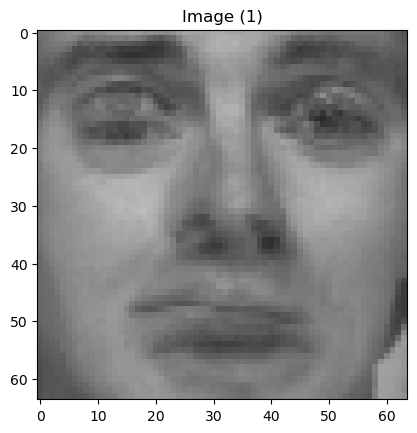

In [30]:
utils.show_images([avg_image])

In [31]:
model_frame_preds = {'class_ids': [], 'max_class_pred': [],
                     'predictions': [], 'avg_pred': []}
# res_list = []

for frame_path in frames:
    frame = cv2.imread(str(frame_path))
    frame = cv2.resize(frame, dsize=(IMG_HEIGHT, IMG_WIDTH))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = frame / 255
    frame = tf.constant(frame, dtype=tf.float32)
    frame = utils.extend_tensor(frame, 0)
    frame = utils.extend_tensor(frame)
    res = model_frame(frame)
    # res_list.append(res)

    model_frame_preds['class_ids'].append(
        res['class_ids'].numpy()[0]
    )
    model_frame_preds['max_class_pred'].append(
        np.max(res['predictions'].numpy()[0])
    )
    model_frame_preds['predictions'].append(
        res['predictions'].numpy()[0]
    )

softmax is not scale invariant, so if the input were [0.1, 0.2, 0.3, 0.4, 0.1, 0.2, 0.3] (which sums to 1.6) the softmax would be [0.125, 0.138, 0.153, 0.169, 0.125, 0.138, 0.153]. This shows that for values between 0 and 1 softmax, in fact, de-emphasizes the maximum value (note that 0.169 is not only less than 0.475, it is also less than the initial proportion of 0.4/1.6=0.25).

https://en.wikipedia.org/wiki/Softmax_function

### Hard Voting

In [32]:
frame_max_idxs = [np.argmax(ar) for ar in model_frame_preds['predictions']]
frame_count_idxs = [frame_max_idxs.count(i) for i in range(len(label_names))]
frame_max_class = np.argmax(frame_count_idxs)

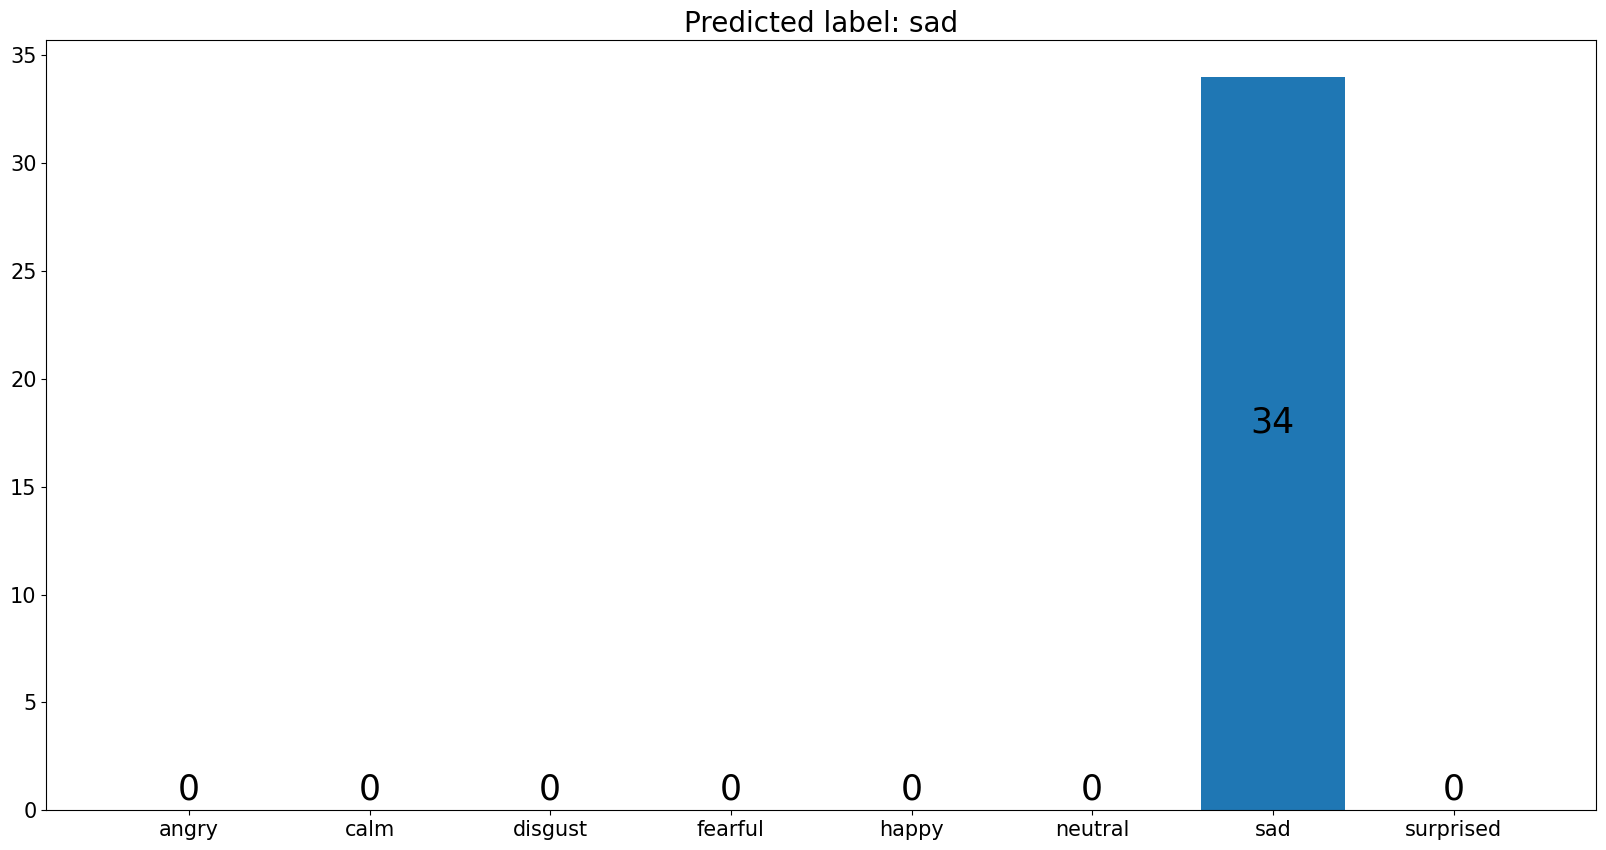

In [33]:
valued_arr = []


fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(20, 10)
)

bar_plot = plt.bar(label_names, frame_count_idxs)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Predicted label: {label_names[frame_max_class]}', fontsize=20)
plt.bar_label(
    bar_plot, label_type='center', fontsize=25, color='black', padding=15
)
plt.show()

### Soft Voting

In [34]:
pred_prob = model_frame_preds['predictions']
if len(frames) > 1:
    pred_prob = np.average(model_frame_preds['predictions'], axis=0)
    # pred_prob = softmax(
    #     np.sum(model_frame_preds['predictions'], axis=0)
    # )

In [35]:
model_frame_preds['avg_pred'].append(pred_prob)

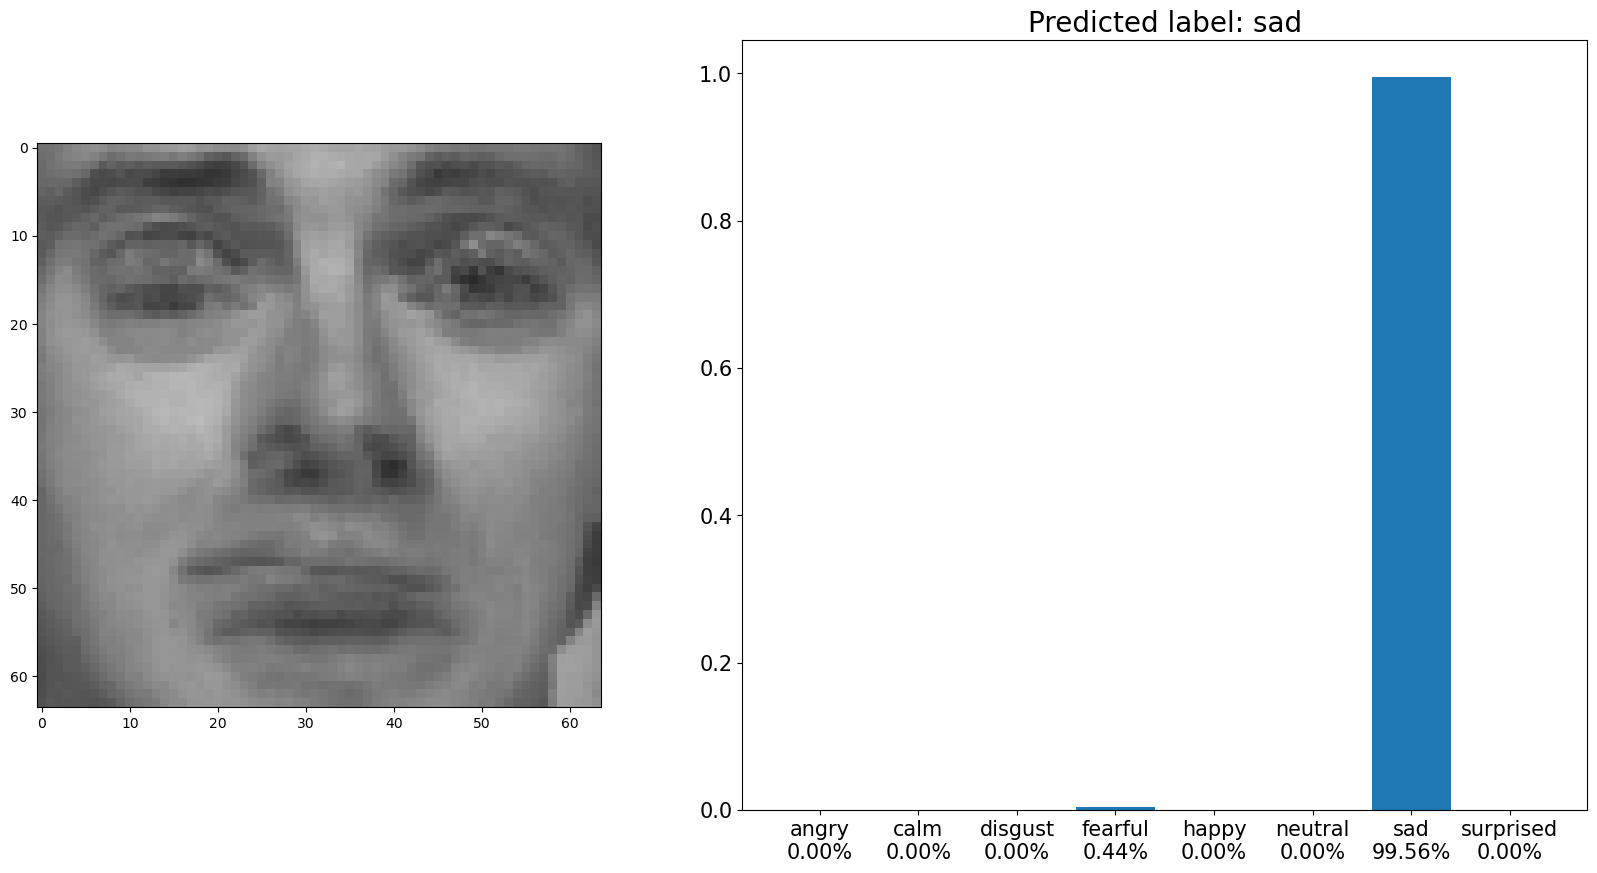

In [36]:
valued_arr = []

for label, pred in zip(label_names, pred_prob):
    # print(label, pred)
    valued_arr.append(f'{label}\n{pred:.2%}')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

pltDisplay(avg_image, ax=ax[0])
bar_plot = ax[1].bar(valued_arr, pred_prob)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Predicted label: {label_names[np.argmax(pred_prob)]}', fontsize=20)

plt.show()

# Model Prediction - Flow

In [38]:
model_flow = tf.saved_model.load(
    Path('Models/Flow/Simple_MNIST/Run_6/E2E/')
)

In [39]:
# TVL1
parameters = {
    'warps': 2,
    'useInitialFlow': False,
    'theta': 0.3,
    'tau': 0.25,
    'scaleStep': 0.8,
    'outerIterations': 3,
    'nscales': 3,
    'medianFiltering': 5,
    'lambda_': 0.15,
    'innerIterations': 3,
    'gamma': 0.0,
    'epsilon': 0.01
}

In [40]:
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)  # Farneback
    # image = tf.image.decode_jpeg(image, channels=3)  # TVL
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255
    return image

In [450]:
reload_module(ut_fl)

Module <module 'utils_flow' from 'C:\\Users\\mic-c\\Documents\\GitHubRepo\\CNN-emotion-recognition\\utils_flow.py'> reloaded


In [41]:
save = True
# test = True  # for choosing the right saving path
view = False  # True if you want to view images while generating
of_mode = 1  # 0: farneback, 1: TVL, 2: pyflow

gen_flows = []
# flows = []

folder_flow_path = Path(folder_path, 'Flow')
folder_flow_path.mkdir(parents=True, exist_ok=True)

total_elements = len(frames)
frame_number = 0

p1 = pb.Progressbar('p1', elements=total_elements)

for prvs_path, next_path in zip(frames[:-1], frames[1:]):

    # prvs = cv2.imread(str(prvs_path))
    prvs = parse_image(str(prvs_path))
    # next = cv2.imread(str(next_path))
    next = parse_image(str(next_path))
    p1.add_to_progress(1)
    frame_number += 1
    # folder_flow_path = Path('test')

    # if (save):
    #     # folder_frame_path.mkdir(parents=True, exist_ok=True)
    #     folder_flow_path.mkdir(parents=True, exist_ok=True)


    flow_string = f'{frame_number:03d}'

    save_string = f'{flow_string}.jpg'

    prvs_rgb = prvs
    # prvs = cv2.cvtColor(prvs, cv2.COLOR_BGR2GRAY)


    next_rgb = next
    # next = cv2.cvtColor(next, cv2.COLOR_BGR2GRAY)

    if (of_mode == 0):
        gr1 = ut_fl.calc_flow_farneback(prvs, next, parameters)
    elif (of_mode == 1):
        gr1 = ut_fl.calc_flow_TVL1(prvs.numpy(), next.numpy(), parameters)
    elif (of_mode == 2):
        gr1 = ut_fl.calc_flow_pyflow(prvs_rgb, next_rgb, parameters)

    # if (save):
    #     # gr1_res = cv2.resize(gr1, dsize=(IMG_HEIGHT, IMG_WIDTH))
    #     cv2.imwrite(str(Path(folder_flow_path, save_string)), gr1)
    cv2.imwrite(str(Path(folder_flow_path, save_string)), gr1)
    gen_flows.append(gr1)
    # flows.append(gr1)

    if (view):
        # cv2.imshow('Vector Flow', draw_flow(next, flow))
        cv2.imshow('Video', prvs)
        # cv2.imshow('BGR Flow', bgr)
        cv2.imshow('GR1 BGRTOGRAY', gr1)
        # cv2.imshow('GR2 SPLIT', gr2)

        k = cv2.waitKey(200) & 0xff
        if k == 27:
            break

    cv2.destroyAllWindows()

p1.update_progress(total_elements)

'Progress: [####################] 100%             34/34'

In [44]:
flows = [str(img) for img in folder_path.glob('Flow/*')]

In [45]:
flow_avg_img = calc_avg_image(flows)

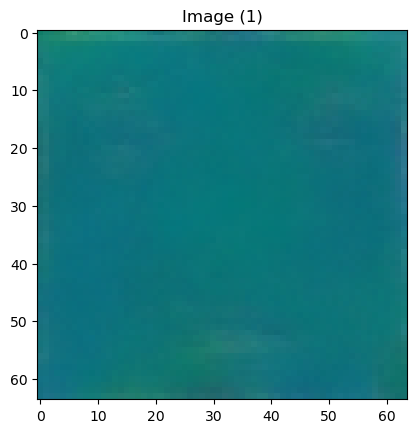

In [46]:
utils.show_images([flow_avg_img])

In [47]:
model_flows_preds = {'class_ids': [], 'max_class_pred': [],
                     'predictions': [], 'avg_pred': []}

for frame_path in flows:
    frame = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
    frame = cv2.resize(frame, dsize=(IMG_HEIGHT, IMG_WIDTH))
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = frame / 255
    frame = tf.constant(frame, dtype=tf.float32)
    frame = utils.extend_tensor(frame, 0)
    frame = utils.extend_tensor(frame)
    res = model_flow(frame)

    model_flows_preds['class_ids'].append(
        res['class_ids'].numpy()[0]
    )
    model_flows_preds['max_class_pred'].append(
        np.max(res['predictions'].numpy()[0])
    )
    model_flows_preds['predictions'].append(
        res['predictions'].numpy()[0]
    )

### Hard Voting

In [48]:
flow_max_idxs = [np.argmax(ar) for ar in model_flows_preds['predictions']]
flow_count_idxs = [flow_max_idxs.count(i) for i in range(len(label_names))]
flow_max_class = np.argmax(flow_count_idxs)

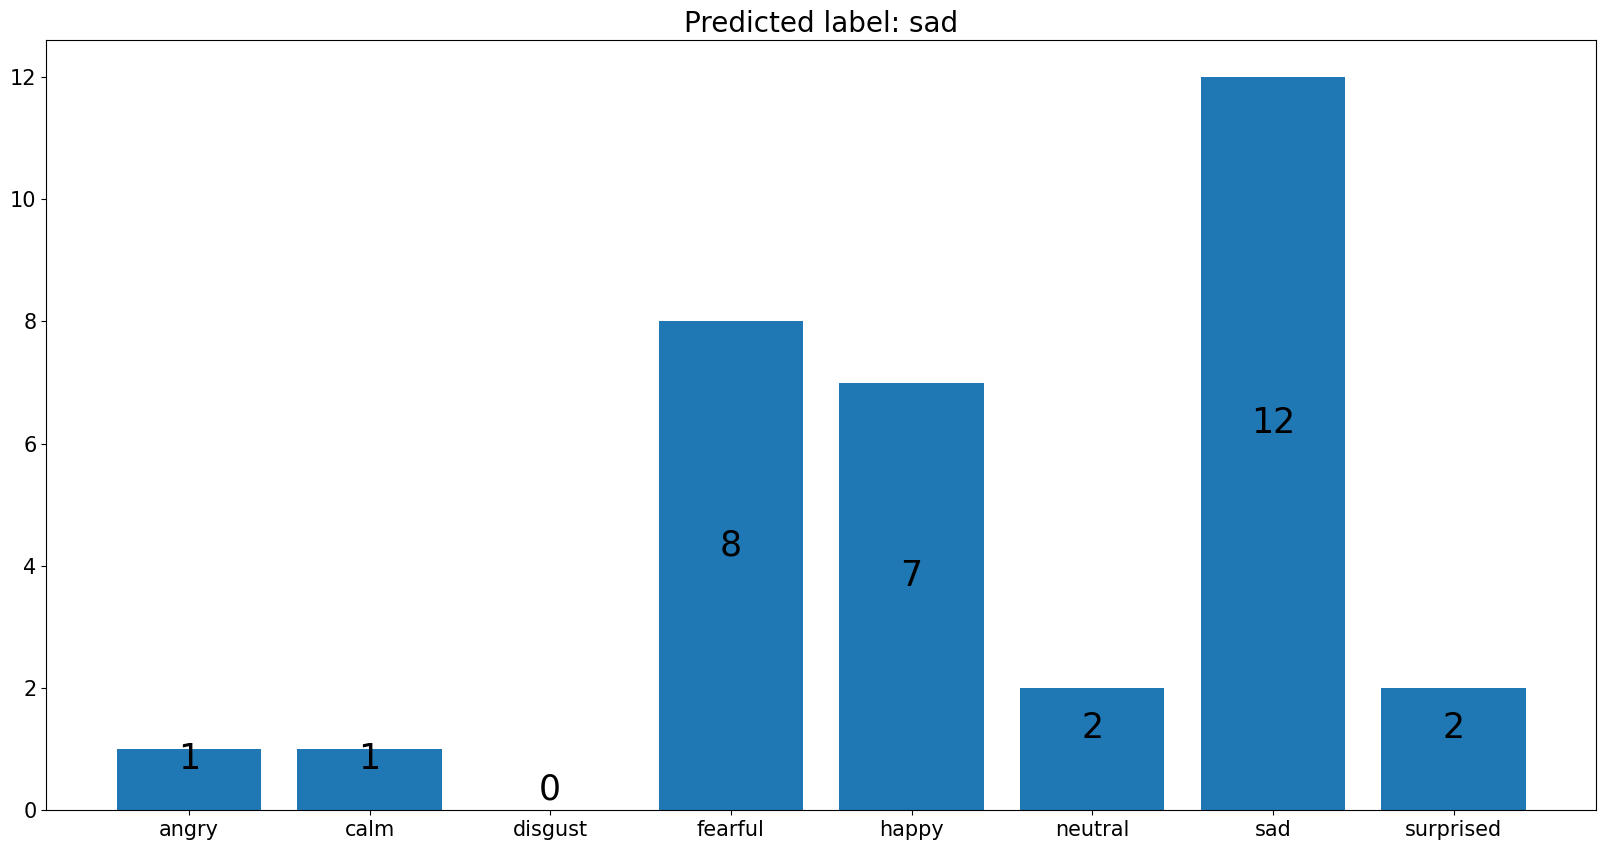

In [49]:
valued_arr = []


fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(20, 10)
)

bar_plot = plt.bar(label_names, flow_count_idxs)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Predicted label: {label_names[flow_max_class]}', fontsize=20)
plt.bar_label(
    bar_plot, label_type='center', fontsize=25, color='black', padding=15
)
plt.show()

### Soft Voting

In [50]:
pred_prob = model_flows_preds['predictions']
if len(frames) > 1:
    pred_prob = np.average(model_flows_preds['predictions'], axis=0)

In [51]:
model_flows_preds['avg_pred'].append(
        pred_prob
    )

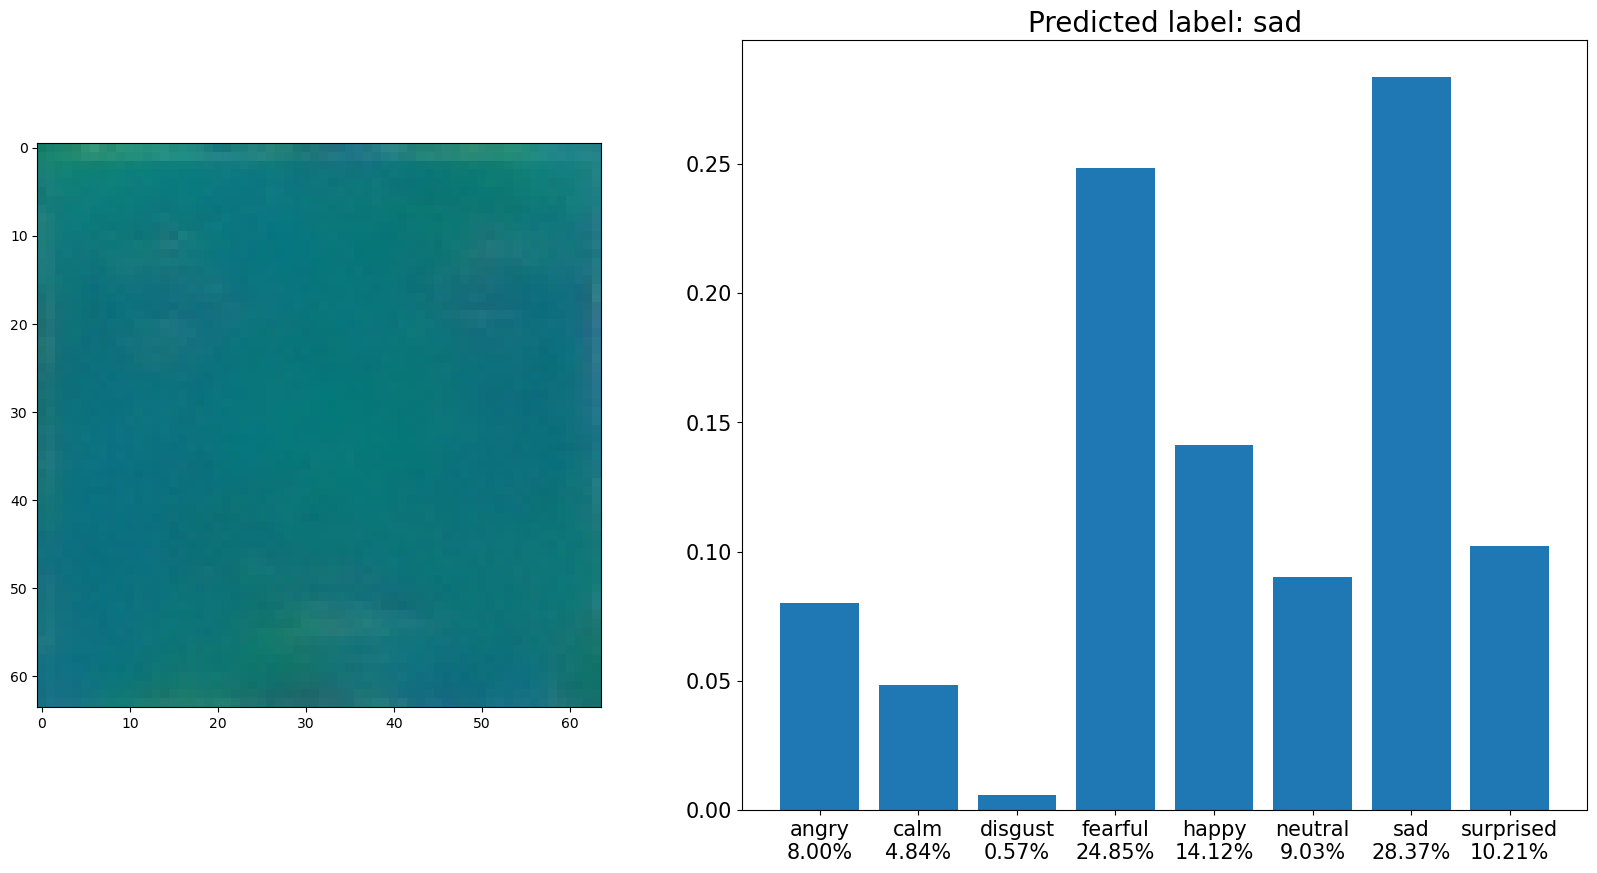

In [52]:
valued_arr = []

for label, pred in zip(label_names, pred_prob):
    # print(label, pred)
    valued_arr.append(f'{label}\n{pred:.2%}')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

pltDisplay(flow_avg_img, ax=ax[0])
ax[1].bar(valued_arr, pred_prob)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Predicted label: {label_names[np.argmax(pred_prob)]}', fontsize=20)
plt.show()

# Model Prediction - Audio

In [140]:
model_speech = tf.saved_model.load(
    Path('Models/Speech/tensorflow_tutorial_model/Run_4/E2E/')
)

In [141]:
# Extract wav from mp4
folder_audio_path = Path(folder_path, 'Audio')
folder_audio_path.mkdir(parents=True, exist_ok=True)
filename = f'{utils.remove_extension(video_path.name)}.wav'
audio_path = str(Path(folder_audio_path, filename))
if not Path(audio_path).is_file():

    command = f'ffmpeg -i {video_path}\
        -ab 160k -ac 2 -ar {SAMPLE_RATE}\
        -vn {audio_path}'

    ret_code = subprocess.call(command, shell=True)
    if ret_code == 0:
        print(f'{audio_path} generated correctly')
    else:
        print(f'ERROR: ret_code: {ret_code}')
else:
    print(f'File {audio_path} already exists')

File test\20240422_090837\Audio\01-01-04-02-01-01-11.wav already exists


In [165]:
audio_file = tf.io.read_file(audio_path)
audio_file, sample_rate = tf.audio.decode_wav(audio_file, desired_channels=1)

In [166]:
frame_len = 48000
hop_len = 12000
model_speech_preds = {
    'class_ids': [], 'max_class_pred': [], 'predictions': [], 'avg_pred': []
}

In [167]:
# padded model
res = model_speech(audio_path)
model_speech_preds['class_ids'].append(
    res['class_ids'].numpy()[0]
)
model_speech_preds['max_class_pred'].append(
    np.max(res['predictions'].numpy()[0])
)
model_speech_preds['predictions'].append(
    res['predictions'].numpy()[0]
)

### Hard Voting

In [175]:
speech_max_idxs = [np.argmax(ar) for ar in model_speech_preds['predictions']]
speech_count_idxs = [speech_max_idxs.count(i) for i in range(len(label_names))]
speech_max_class = np.argmax(speech_count_idxs)

In [176]:
speech_max_idxs, speech_max_class, speech_count_idxs

([3], 3, [0, 0, 0, 1, 0, 0, 0, 0])

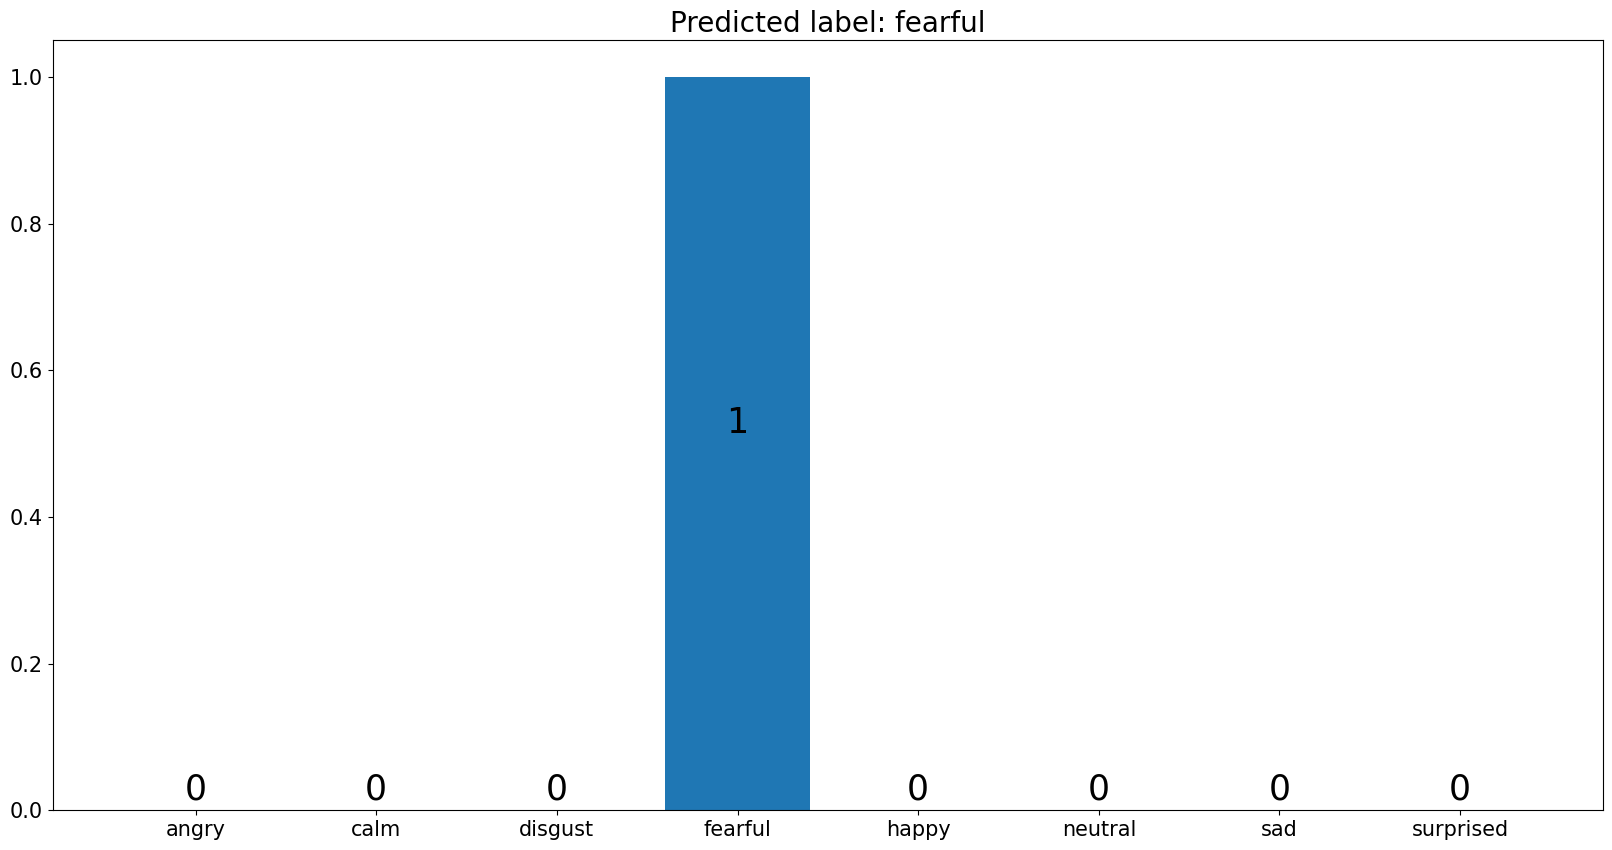

In [177]:
valued_arr = []


fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(20, 10)
)

bar_plot = plt.bar(label_names, speech_count_idxs)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Predicted label: {label_names[speech_max_class]}', fontsize=20)
plt.bar_label(
    bar_plot, label_type='center', fontsize=25, color='black', padding=15
)
plt.show()

### Soft Voting

In [178]:
pred_prob = softmax(model_speech_preds['predictions'][0])

In [179]:
model_speech_preds['avg_pred'].append(
        pred_prob
    )

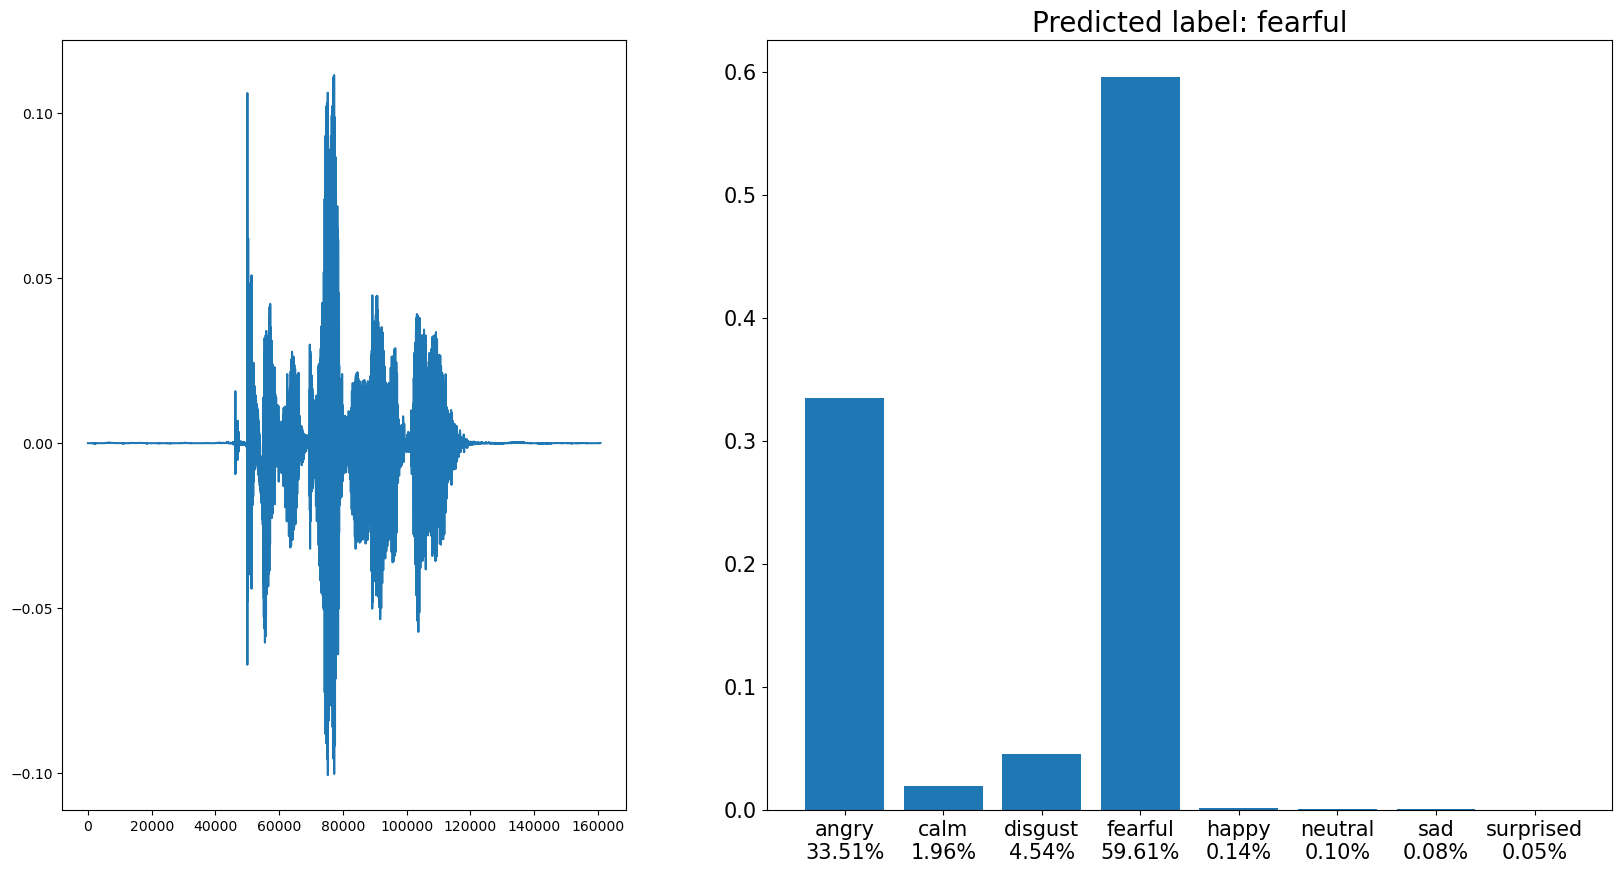

In [180]:
valued_arr = []

for label, pred in zip(label_names, pred_prob):
    # print(label, pred)
    valued_arr.append(f'{label}\n{pred:.2%}')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

ax[0].plot(audio_file)
ax[1].bar(valued_arr, pred_prob)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Predicted label: {label_names[np.argmax(pred_prob)]}', fontsize=20)
plt.show()

# Average of the three models

In [181]:
avg_frame = model_frame_preds['avg_pred'][0]
avg_flow = model_flows_preds['avg_pred'][0]
avg_audio = model_speech_preds['avg_pred'][0]

## Simple Average

In [182]:
#  Simple Average
simple_average = (
    np.average([avg_frame, avg_flow, avg_audio], axis=0)
)

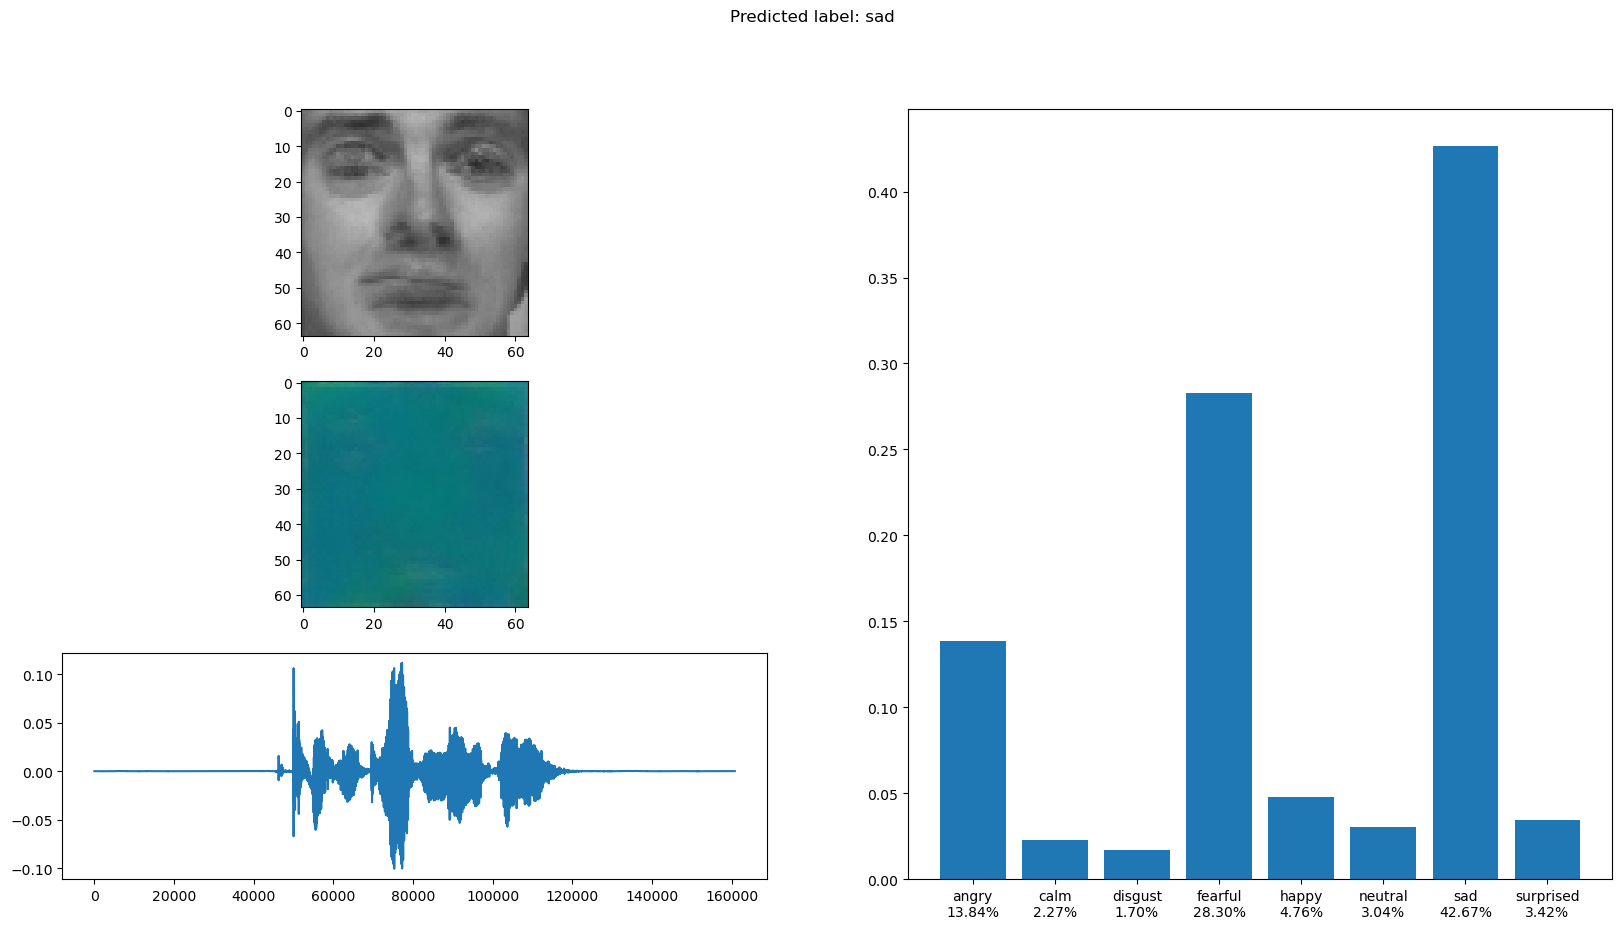

In [183]:
valued_arr = []

for label, pred in zip(label_names, simple_average):
    # print(label, pred)
    valued_arr.append(f'{label}\n{pred:.2%}')


# fig, ax = plt.subplots(
#     figsize=(20, 10)
# )
fig = plt.figure(figsize=(20, 10))
fig.suptitle(f'Predicted label: {label_names[np.argmax(simple_average)]}')

ax1 = fig.add_subplot(122)
ax1.bar(valued_arr, simple_average)

ax2 = fig.add_subplot(321)
pltDisplay(avg_image, ax=ax2)

ax3 = fig.add_subplot(323)
pltDisplay(flow_avg_img, ax=ax3)

ax4 = fig.add_subplot(325)
ax4.plot(audio_file)
# ax[0, 1].bar(valued_arr, final_model_preds)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

plt.show()

## Weighted Average (TEST)

In [184]:
#  Weighted Average
weights = [0.6, 0.2, 0.2]

weighted_average = (
    np.average(a=[avg_frame, avg_flow, avg_audio], axis=0, weights=weights)
)

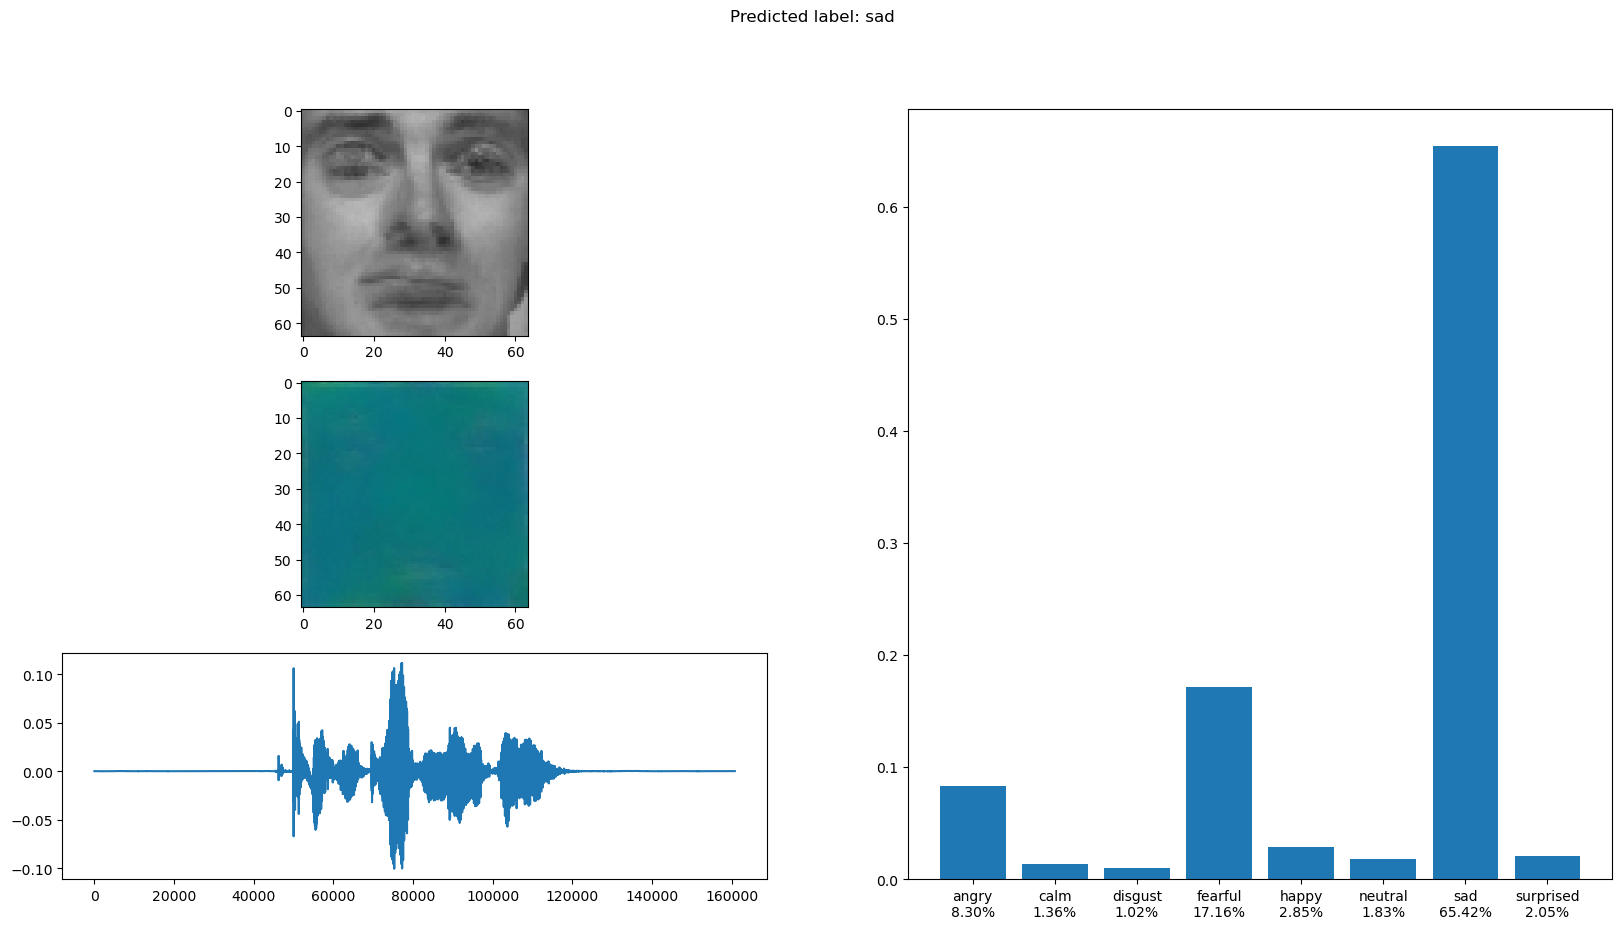

In [185]:
valued_arr = []

for label, pred in zip(label_names, weighted_average):
    # print(label, pred)
    valued_arr.append(f'{label}\n{pred:.2%}')


# fig, ax = plt.subplots(
#     figsize=(20, 10)
# )
fig = plt.figure(figsize=(20, 10))
fig.suptitle(f'Predicted label: {label_names[np.argmax(weighted_average)]}')

ax1 = fig.add_subplot(122)
ax1.bar(valued_arr, weighted_average)

ax2 = fig.add_subplot(321)
pltDisplay(avg_image, ax=ax2)

ax3 = fig.add_subplot(323)
pltDisplay(flow_avg_img, ax=ax3)

ax4 = fig.add_subplot(325)
ax4.plot(audio_file)
# ax[0, 1].bar(valued_arr, final_model_preds)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

plt.show()

# Max Voting

In [186]:
count_idx = np.sum(
    [frame_count_idxs, flow_count_idxs, speech_count_idxs],
    axis=0
)

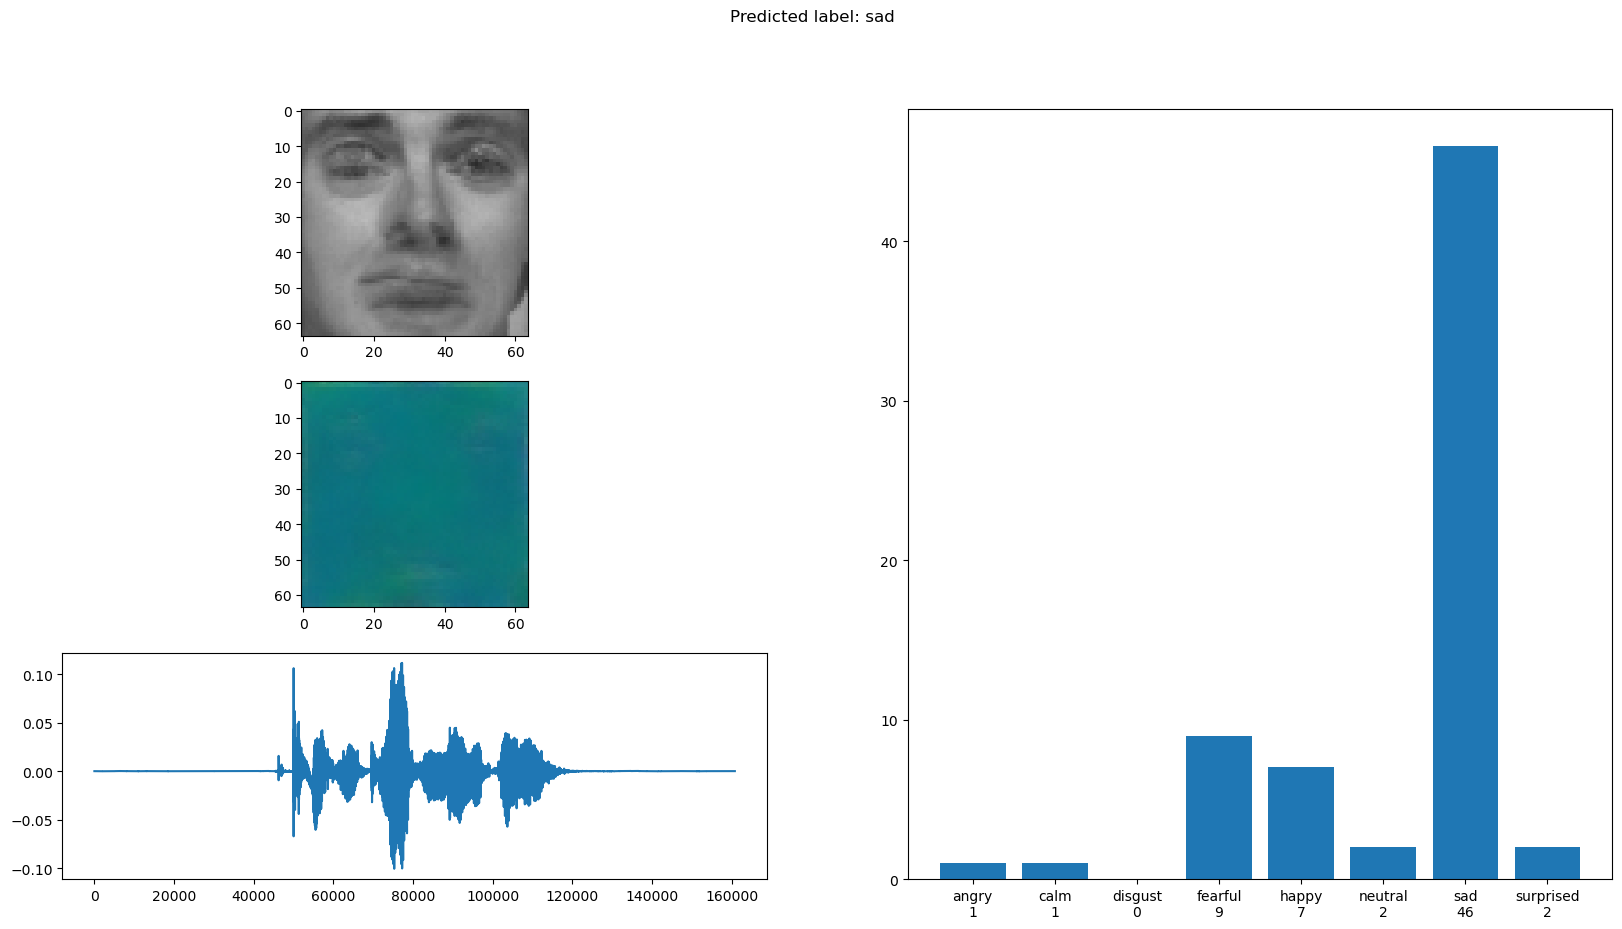

In [187]:
valued_arr = []

for label, pred in zip(label_names, count_idx):
    # print(label, pred)
    valued_arr.append(f'{label}\n{pred}')


# fig, ax = plt.subplots(
#     figsize=(20, 10)
# )
fig = plt.figure(figsize=(20, 10))
fig.suptitle(f'Predicted label: {label_names[np.argmax(count_idx)]}')

ax1 = fig.add_subplot(122)
ax1.bar(valued_arr, count_idx)

ax2 = fig.add_subplot(321)
pltDisplay(avg_image, ax=ax2)

ax3 = fig.add_subplot(323)
pltDisplay(flow_avg_img, ax=ax3)

ax4 = fig.add_subplot(325)
ax4.plot(audio_file)
# ax[0, 1].bar(valued_arr, final_model_preds)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

plt.show()